In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel

In [142]:
df = pd.read_csv('Final_2_cleaned.csv')

In [122]:
df.head(10)

,Rank,Ticker,Company Name,Industry,Sector,Country,Profit (Billion $),Revenue (Billion $),Assets (Billion $),Market Value (Billion $),...,Gender,EBITDA,Rating,Beta,No of Employees,Founding Year,Profit_Margin,ROA,EBITDA_to_Revenue,Market_to_Book
0,1.0,JPM,JPMorganChase,Banks - Diversified,Financial Services,United States,50.0,252.9,4090.7,588.1,...,Male,74.63,3,1.09,317233,1980,0.197707,0.012223,0.295097,0.182805
1,2.0,BRK-B,Berkshire Hathaway,Insurance - Diversified,Financial Services,United States,73.4,369.0,1070.0,899.1,...,Male,0.00,3,0.86,392400,1996,0.198916,0.068598,0.000000,0.944327
2,3.0,2222.SR,Saudi Arabian Oil Company (Saudi Aramco),Oil & Gas Integrated,Energy,Saudi Arabia,116.9,489.1,661.5,1919.3,...,Male,996.71,3,0.17,67947,2019,0.239010,0.176720,2.037845,10.126969
3,4.0,1398.HK,ICBC,Banks - Diversified,Financial Services,China,50.4,223.8,6586.0,215.2,...,Male,12.18,3,0.97,72000,1980,0.225201,0.007653,0.054424,0.371863
4,5.0,BAC,Bank of America,Banks - Diversified,Financial Services,United States,25.0,183.3,3273.8,307.3,...,Male,29.25,3,1.33,213000,1973,0.136388,0.007636,0.159574,0.107636
5,6.0,AMZN,Amazon,Internet Retail,Consumer Cyclical,United States,37.7,590.7,531.0,1922.1,...,Male,123.82,3,1.19,1556000,1997,0.063823,0.070998,0.209616,4.706610
6,7.0,601939.SS,China Construction Bank,Banks - Diversified,Financial Services,China,47.0,199.8,5403.8,187.5,...,Male,12.18,3,0.97,72000,1980,0.235235,0.008698,0.060961,0.275195
7,8.0,MSFT,Microsoft,Software - Infrastructure,Technology,United States,86.2,236.6,484.3,3123.1,...,Male,133.01,3,0.90,228000,1986,0.364328,0.177989,0.562172,6.371154
8,9.0,601288.SS,Agricultural Bank of China,Banks - Diversified,Financial Services,China,37.4,193.5,5832.9,170.9,...,Male,12.18,3,0.97,72000,1980,0.193282,0.006412,0.062946,0.303208
9,10.0,GOOG,Alphabet,Internet Content & Information,Communication Services,United States,82.4,317.9,407.4,2177.7,...,Male,112.39,4,1.02,183323,2004,0.259201,0.202258,0.353539,6.151595


In [ ]:
numeric_cols = ['Profit (Billion $)', 'Revenue (Billion $)', 
                'Assets (Billion $)', 'EBITDA', 'Market Cap(Billion $)']
target = 'Rating'

In [117]:
df[target] = pd.to_numeric(df[target], errors='coerce')
rating_median = df[target].median()
df[target] = df[target].fillna(rating_median).astype(int)

for col in numeric_cols:
    col_median = df[col].median()
    df[col] = pd.to_numeric(df[col], errors='coerce')  # ensure numeric
    df[col] = df[col].fillna(col_median)

In [ ]:
# Feature Engineering
df['Profit_Margin'] = df['Profit (Billion $)'] / df['Revenue (Billion $)']
df['ROA'] = df['Profit (Billion $)'] / df['Assets (Billion $)']
df['EBITDA_to_Revenue'] = df['EBITDA'] / df['Revenue (Billion $)']
df['Market_to_Book'] = df['Market Cap(Billion $)'] / df['Assets (Billion $)']

In [ ]:
ratio_cols = ['Profit_Margin', 'ROA', 'EBITDA_to_Revenue', 'Market_to_Book']
for col in ratio_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    df[col] = df[col].fillna(df[col].median())

In [ ]:
features = numeric_cols + ratio_cols

In [ ]:
print("Sample of processed data:")
print(df[features + [target]].head(10))

Sample of processed data:
   Profit (Billion $)  Revenue (Billion $)  Assets (Billion $)  EBITDA  \
0                50.0                252.9              4090.7   74.63   
1                73.4                369.0              1070.0    0.00   
2               116.9                489.1               661.5  996.71   
3                50.4                223.8              6586.0   12.18   
4                25.0                183.3              3273.8   29.25   
5                37.7                590.7               531.0  123.82   
6                47.0                199.8              5403.8   12.18   
7                86.2                236.6               484.3  133.01   
8                37.4                193.5              5832.9   12.18   
9                82.4                317.9               407.4  112.39   

   Market Cap(Billion $)  Profit_Margin       ROA  EBITDA_to_Revenue  \
0                 747.80       0.197707  0.012223           0.295097   
1              

In [ ]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

In [68]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print("Class distribution in training set:", pd.Series(y_train).value_counts().to_dict())
print("Class distribution in testing set:", pd.Series(y_test).value_counts().to_dict())

Training set size: 142 samples
Testing set size: 48 samples
Class distribution in training set: {3: 103, 2: 28, 4: 11}
Class distribution in testing set: {3: 35, 2: 10, 4: 3}


In [ ]:
print("Training set sample:")
print(X_train.head())
print(y_train.head())


Training set sample:
     Profit (Billion $)  Revenue (Billion $)  Assets (Billion $)  EBITDA  \
117                 4.8                191.7               117.9  236.79   
70                  8.8                 92.5               195.6   12.18   
31                 11.3                134.0               380.2   47.52   
115                 6.6                 51.6               818.1   12.18   
50                 14.4                164.3               288.5   12.18   

     Market Cap(Billion $)  Profit_Margin       ROA  EBITDA_to_Revenue  \
117                  75.69       0.025039  0.040712           1.235211   
70                   80.16       0.095135  0.044990           0.131676   
31                  165.82       0.084328  0.029721           0.354627   
115                1010.18       0.127907  0.008067           0.236047   
50                   54.30       0.087645  0.049913           0.074133   

     Market_to_Book  
117        0.641985  
70         0.409816  
31         

In [ ]:
print("\nTesting set sample:")
print(X_test.head())
print(y_test.head())


Testing set sample:
     Profit (Billion $)  Revenue (Billion $)  Assets (Billion $)  EBITDA  \
122                 3.9                177.5               274.3   14.24   
75                 10.6                 52.5               137.1   21.58   
16                 17.9                289.7               402.0   58.49   
60                  4.8                121.5               318.8   12.18   
78                  9.6                102.8               137.2   39.56   

     Market Cap(Billion $)  Profit_Margin       ROA  EBITDA_to_Revenue  \
122                  40.06       0.021972  0.014218           0.080225   
75                  475.65       0.201905  0.077316           0.411048   
16                  200.51       0.061788  0.044527           0.201899   
60                  161.81       0.039506  0.015056           0.100247   
78                   65.73       0.093385  0.069971           0.384825   

     Market_to_Book  
122        0.146044  
75         3.469365  
16         

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
class_counts = Counter(y_train)
n_samples = len(y_train)
n_classes = len(class_counts)

In [ ]:
class_weights = {cls: n_samples / (n_classes * count) for cls, count in class_counts.items()}
print("Computed class weights:", class_weights)

Computed class weights: {2: 1.6904761904761905, 3: 0.459546925566343, 4: 4.303030303030303}


In [ ]:
def combined_kernel(X, Y):
    gamma_rbf = 0.1
    degree_poly = 2
    coef0 = 1.0
    
    rbf_component = rbf_kernel(X, Y, gamma=gamma_rbf)
    poly_component = polynomial_kernel(X, Y, degree=degree_poly, coef0=coef0)

    return 0.7 * rbf_component + 0.3 * poly_component

In [ ]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid', 'precomputed']
costs = [0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
results = {}

In [ ]:
print("\nRunning grid search for standard kernels...")
param_grid = {
    'C': costs,
    'kernel': kernels[:4],  
    'gamma': gammas,
    'class_weight': [class_weights, 'balanced']
}


Running grid search for standard kernels...


In [131]:
grid_search = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': [{2: 1.6904761904761905,
                                           3: 0.459546925566343,
                                           4: 4.303030303030303},
                                          'balanced'],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [132]:
best_model = grid_search.best_estimator_
print(f"\nBest standard kernel model: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2%}")


Best standard kernel model: {'C': 100, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Best score: 57.12%


In [ ]:
standard_preds = best_model.predict(X_test_scaled)
standard_acc = accuracy_score(y_test, standard_preds)
standard_cm = confusion_matrix(y_test, standard_preds)

In [ ]:
print("\nEvaluating custom combined kernel...")

K_train = combined_kernel(X_train_scaled, X_train_scaled)
K_test = combined_kernel(X_test_scaled, X_train_scaled)


Evaluating custom combined kernel...


In [ ]:
custom_results = []
for C in costs:
    model = SVC(
        kernel='precomputed',
        C=C,
        class_weight=class_weights
    )
    model.fit(K_train, y_train)
    custom_preds = model.predict(K_test)
    custom_acc = accuracy_score(y_test, custom_preds)
    custom_cm = confusion_matrix(y_test, custom_preds)
    
    custom_results.append({
        'C': C,
        'accuracy': custom_acc,
        'confusion_matrix': custom_cm
    })

In [136]:
best_custom = max(custom_results, key=lambda x: x['accuracy'])
print(f"Best combined kernel results (C={best_custom['C']}): {best_custom['accuracy']:.2%}")

Best combined kernel results (C=100): 52.08%


In [ ]:
if best_custom['accuracy'] > standard_acc:
    print("\nCombined kernel performs better!")
    best_acc = best_custom['accuracy']
    best_cm = best_custom['confusion_matrix']
    best_type = "Combined RBF+Poly"
    best_params = f"C={best_custom['C']}"
else:
    print("\nStandard kernel performs better!")
    best_acc = standard_acc
    best_cm = standard_cm
    best_type = grid_search.best_params_['kernel']
    best_params = f"C={grid_search.best_params_['C']}, gamma={grid_search.best_params_['gamma']}"


Standard kernel performs better!


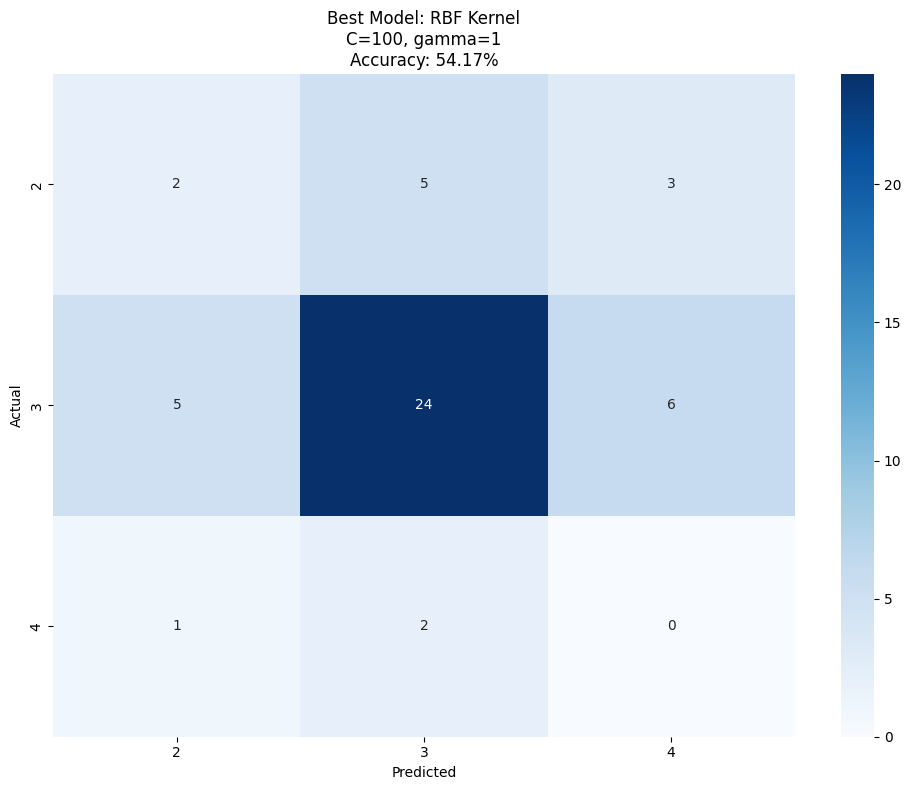

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(best_cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=sorted(np.unique(y)),
            yticklabels=sorted(np.unique(y)))
plt.title(f'Best Model: {best_type.upper()} Kernel\n{best_params}\nAccuracy: {best_acc:.2%}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
accuracies = []

for param in grid_search.cv_results_['params']:
    if param['class_weight'] == 'balanced':
        accuracies.append({
            'Kernel': f"{param['kernel']} (C={param['C']}, γ={param['gamma']})",
            'Accuracy': grid_search.cv_results_['mean_test_score'][
                grid_search.cv_results_['params'].index(param)
            ]
        })

accuracies.append({
    'Kernel': f"Combined RBF+Poly (C={best_custom['C']})",
    'Accuracy': best_custom['accuracy']
})

<Figure size 1200x600 with 0 Axes>

/var/folders/bh/k3v2d3ls0nl17y_3v8vz8blm0000gn/T/ipykernel_76017/4089904547.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Kernel', data=acc_df_sorted, palette='Blues_d')


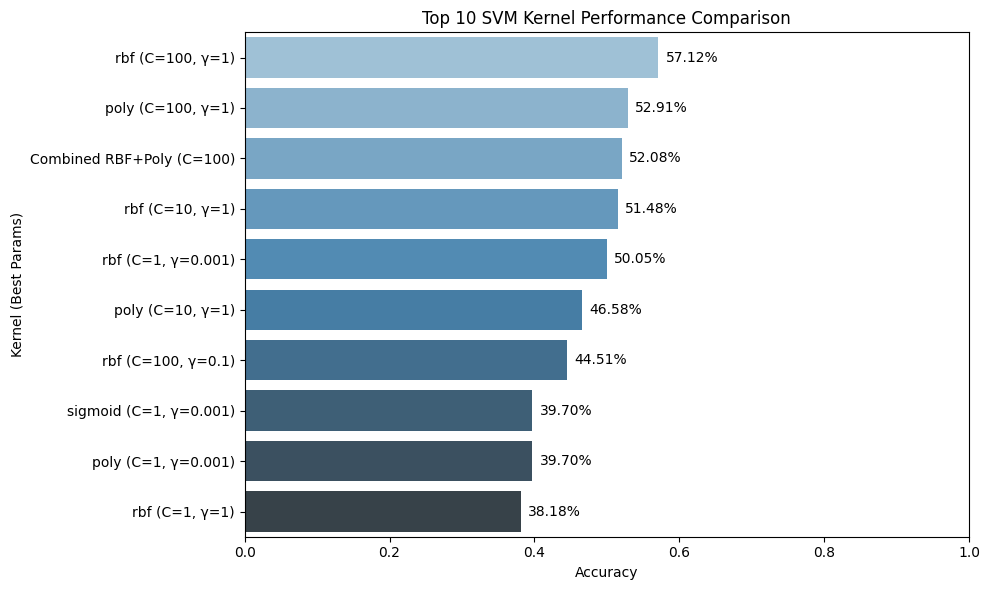

In [ ]:
N = 10
acc_df_sorted = acc_df.sort_values('Accuracy', ascending=False).head(N)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Kernel', data=acc_df_sorted, palette='Blues_d')
plt.title(f'Top {N} SVM Kernel Performance Comparison')
plt.xlim(0, 1.0)
plt.xlabel('Accuracy')
plt.ylabel('Kernel (Best Params)')
for i, (acc, kernel) in enumerate(zip(acc_df_sorted['Accuracy'], acc_df_sorted['Kernel'])):
    plt.text(acc + 0.01, i, f"{acc:.2%}", va='center', fontsize=10)
plt.tight_layout()
plt.show()